In [1]:
import numpy as np
from numpy.linalg import inv
import timeit
import cvxpy as cp

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set(rc={'figure.figsize': (14, 8.27)}, font_scale=2)
sns.set_palette('colorblind')

$min_x$$||Ax-b||_2^2 + lambda||x||_1$

# A)

$min_x$$ ||Ax-b||_2^2 + lambda||x||_1 $

$min_x$$||x||_1 = min_x \sum_{i=1}^n |  x_i |$
$min_x$$||x||_1 = min_x \sum_{i=1}^n min_{u_i}( -u_i \leq x_i \leq u_i)$

combining with the ll2 norm term, we get $min_{x,u_i} ||Ax-b||_2^2 + lambda \sum_{i=1}^n u_i$
sunbject to $-u_i \leq x_i \leq u_i$ for $i=1,...,n$
To enforce this we use the barrier function $-\sum_{i=1}^n log(u_i-x_i) + log(u_i+x_i) = -\sum_{i=1}^n log(u_i^2-x_i^2)$

Finally, we minimise $t\sum_i^m \left( \sum_j^n a_{ij} x_j - b_i \right) ^2 + t lambda -\sum_{j=1}^n log(u_j-x_j) + log(u_j+x_j) $

$$ \tilde{x} =
\left(\begin{array}{cc}
x \\
u
\end{array}\right)
$$

In [3]:
def f(A, b, x_til, lam, t):
    n =256
    x, u = x_til[:n], x_til[n:]
    if (u-x < 0).any() or (u+x < 0).any():
        return 'infeasible'
    residual = A @ x - b
    return t*residual.T @ residual + t*lam*np.sum(u) - np.sum(np.log(u-x) + np.log(u+x))

# B)

## Gradient

$\frac{\partial f}{\partial x_k}$$ = 2 t \sum_i^m  \sum_j^n ( a_{ij} x_j - b_i ) a_{ik} + \frac{1}{u_k-x_k} - \frac{1}{u_k+x_k}$

In [4]:
def grad_f_x(A, b, x_til, t):
    n =256
    x, u = x_til[:n], x_til[n:]
    gradient = 2*t*(A.T @ A @ x - A.T @ b) + 1/(u - x) - 1/(u + x)
    return gradient

$\frac{\partial f}{\partial u_k}$$ = tlambda - \frac{1}{u_k-x_k} - \frac{1}{u_k+x_k}$

In [5]:
def grad_f_u(x_til, t, lam):
    n =256
    x, u = x_til[:n], x_til[n:]
    gradient = t*lam - 1/(u - x) - 1/(u + x)
    return gradient

In [6]:
def grad_f(A, b, x_til, t, lam):
    return np.concatenate((grad_f_x(A, b, x_til, t), grad_f_u(x_til, t, lam)))

## Hessian

$H_{11}$$ = \frac{\partial^2 f}{\partial x^2} = 2tA^TA + diag \left( \frac{1}{u_k+x_k} + \frac{1}{u_k-x_k}, .... \right)$

In [7]:
def grad_f_xx(A, x_til, t):
    n =256
    x, u = x_til[:n], x_til[n:]
    gradient = 2*t*A.T @ A + np.diag(1/np.square(u + x) + 1/np.square(u - x))
    return gradient

$H_{12}$$ = $$H_{21}$$ = \frac{\partial^2 f}{\partial x \partial u} = diag \left( \frac{1}{u_k+x_k} - \frac{1}{u_k-x_k}, .... \right)$

In [8]:
def grad_f_xu(x_til):
    n =256
    x, u = x_til[:n], x_til[n:]
    gradient = np.diag(1/np.square(u + x) - 1/np.square(u - x))
    return gradient

$H_{22}$$ = \frac{\partial^2 f}{\partial u^2} = diag \left( \frac{1}{u_k+x_k} + \frac{1}{u_k-x_k}, .... \right)$

In [9]:
def grad_f_uu(x_til):
    n =256
    x, u = x_til[:n], x_til[n:]
    gradient = np.diag(1/np.square(u + x) + 1/np.square(u - x))
    return gradient

$$ \tilde{H} =
\left(\begin{array}{cc}
H_{11} & H_{12}\\
H_{21} & H_{22}
\end{array}\right)
$$

In [10]:
def hessian_f(A, x_til, t):
    h_11 = grad_f_xx(A, x_til, t)
    h_12 = grad_f_xu(x_til)
    h_22 = grad_f_uu(x_til)
    return np.block([[h_11, h_12],[h_12, h_22]])

# C)

In [11]:
A = np.genfromtxt('2023-data/A.csv', delimiter=",")
x_0 = np.genfromtxt('2023-data/x.csv', delimiter=",")

In [12]:
b = A @ x_0 + np.random.uniform(-0.005, 0.005, A.shape[0])

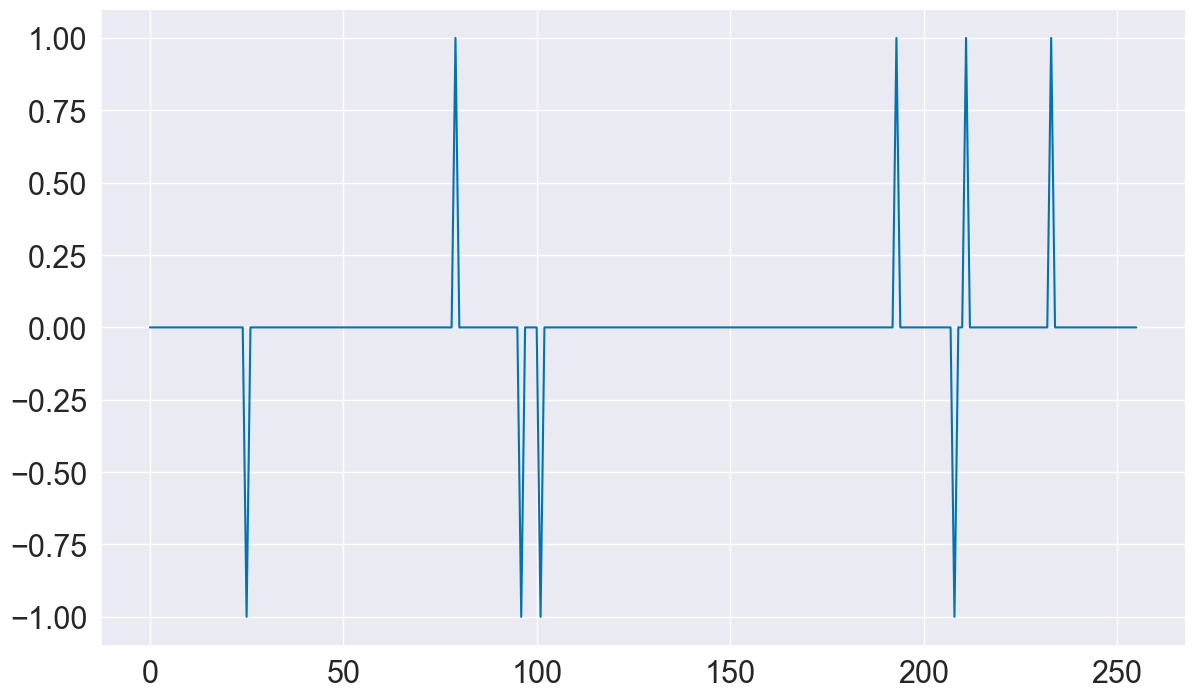

In [26]:
plt.plot(x_0)
plt.savefig('Figures/ex3_signal.png', format="png", dpi=800, bbox_inches="tight")
plt.show()
plt.close()

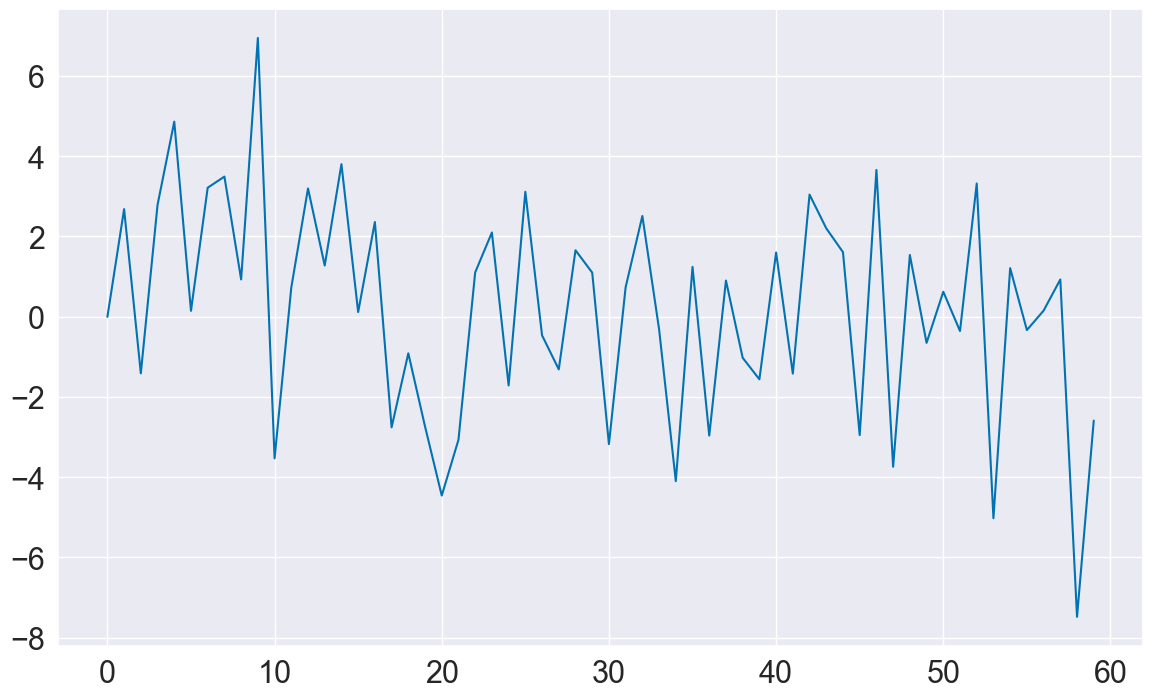

In [27]:
plt.plot(b)
plt.savefig('Figures/ex3_noisy.png', format="png", dpi=800, bbox_inches="tight")
plt.show()
plt.close()

In [14]:
def N_decrement(A, b, x_til, t, lam):
    jacobian = grad_f(A, b, x_til, t, lam)
    return (jacobian.T @ np.linalg.inv(hessian_f(A, x_til, t)) @ jacobian)/2

In [15]:
def Newtons_method(x_til_start, epsilon, t, lam_factor):
    lam_max = np.linalg.norm(2 * A.T @ b, ord=np.inf)
    lam = lam_factor * lam_max
    beta = 0.8
    iterations = 0
    x_til = x_til_start
    func = f(A, b, x_til, lam, t)
    costs = [func]
    grad = grad_f(A, b, x_til, t, lam)
    hessian = hessian_f(A, x_til, t)
    step = - np.linalg.inv(hessian) @ grad

    print(f't: {t}, Iteration: {iterations}, func: {func}')

    while (grad.T @ - step)/2 >= epsilon:
        t_b = 1
        while f(A, b, x_til + t_b * step, lam, t) == 'infeasible':
            t_b = t_b * beta
        x_til = x_til + t_b * step
        iterations += 1
        grad = grad_f(A, b, x_til, t, lam)
        hessian = hessian_f(A, x_til, t)
        step = - np.linalg.inv(hessian) @ grad
        func = f(A, b, x_til, lam, t)
        costs.append(func)
        print(f't: {t}, Iteration: {iterations}, func: {func}')
    return x_til, costs

In [28]:
x_til = np.concatenate((np.zeros(256), np.ones(256)))
ep = 0.1
for lam_factor in [0.01]:
    costs = []
    for t in [1, 10, 100, 1000, 10000]:
        x_til, cost = Newtons_method(x_til, ep, t, lam_factor)
        costs = costs + cost

t: 1, Iteration: 0, func: 899.6824148563584
t: 1, Iteration: 1, func: 461.7777160886265
t: 10, Iteration: 0, func: 5027.217526095859
t: 10, Iteration: 1, func: 1949.6044426674052
t: 10, Iteration: 2, func: 1742.3264039270814
t: 10, Iteration: 3, func: 1726.516547181212
t: 10, Iteration: 4, func: 1725.323518599194
t: 100, Iteration: 0, func: 7425.886291220953
t: 100, Iteration: 1, func: 4448.182814237147
t: 100, Iteration: 2, func: 4180.429542645939
t: 100, Iteration: 3, func: 4165.73407451786
t: 100, Iteration: 4, func: 4163.796673895511
t: 1000, Iteration: 0, func: 21533.999335321714
t: 1000, Iteration: 1, func: 18449.239207078674
t: 1000, Iteration: 2, func: 18227.303811538804
t: 1000, Iteration: 3, func: 18210.92120452509
t: 1000, Iteration: 4, func: 18209.02176924213
t: 1000, Iteration: 5, func: 18208.615382900683
t: 10000, Iteration: 0, func: 151629.77480530847
t: 10000, Iteration: 1, func: 148575.81440616335
t: 10000, Iteration: 2, func: 148312.84867162374
t: 10000, Iteration: 3,

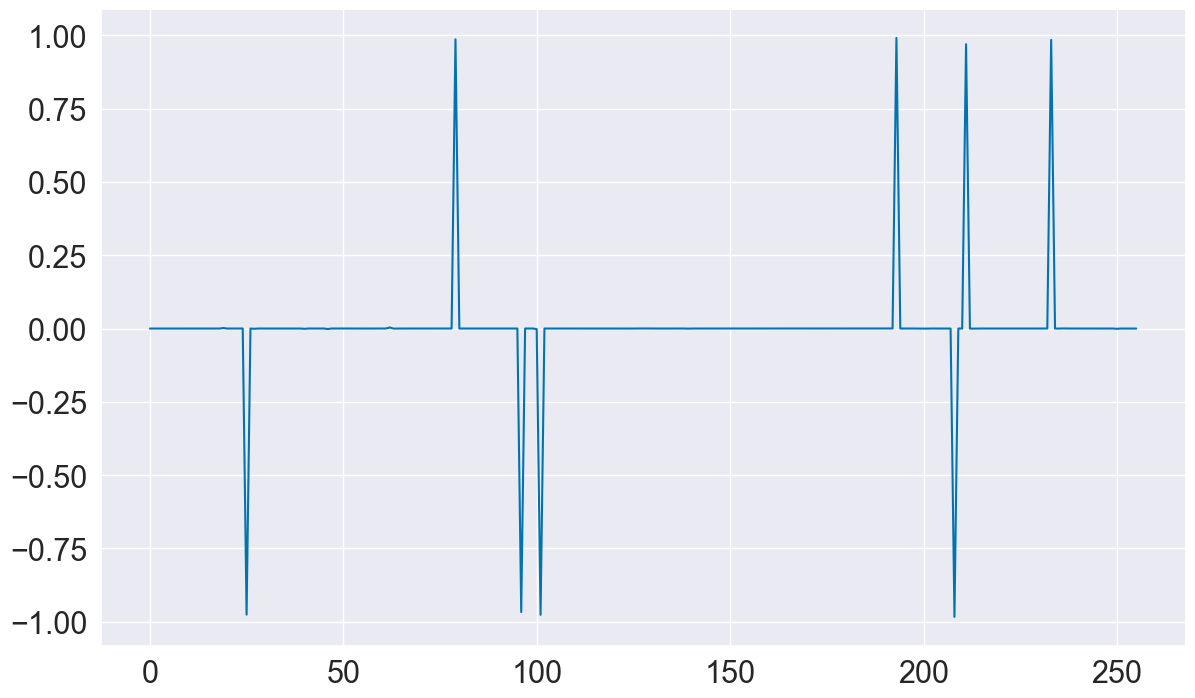

In [29]:
plt.plot(x_til[:256])
plt.savefig('Figures/ex3_signal_recon.png', format="png", dpi=800, bbox_inches="tight")
plt.show()
plt.close()

# D)

In [32]:
x_til_opt = np.concatenate((np.zeros(256), np.ones(256)))
ep = 0.1
x_opt = []
for lam_factor in [0.5, 0.01, 0.001]:
    for t in [1, 10, 100]:
        x_til_opt, cost = Newtons_method(x_til_opt, ep, t, lam_factor)
    x_opt.append(x_til_opt[:256])

t: 1, Iteration: 0, func: 23574.140116466224
t: 1, Iteration: 1, func: 5954.1952643319655
t: 1, Iteration: 2, func: 3194.732755930788
t: 1, Iteration: 3, func: 2834.685209727095
t: 1, Iteration: 4, func: 2812.4746632202587
t: 1, Iteration: 5, func: 2807.296575318527
t: 10, Iteration: 0, func: 10853.741911777966
t: 10, Iteration: 1, func: 7838.611647877082
t: 10, Iteration: 2, func: 7540.270421738137
t: 10, Iteration: 3, func: 7516.634110226235
t: 10, Iteration: 4, func: 7513.37619865198
t: 10, Iteration: 5, func: 7513.201874716621
t: 100, Iteration: 0, func: 47523.74565354399
t: 100, Iteration: 1, func: 44427.30589639682
t: 100, Iteration: 2, func: 44195.06459277179
t: 100, Iteration: 3, func: 44145.46727810846
t: 100, Iteration: 4, func: 44144.010040723355
t: 100, Iteration: 5, func: 44143.482176521386
t: 100, Iteration: 6, func: 44143.35246947799
t: 1, Iteration: 0, func: 4498.756680964824
t: 1, Iteration: 1, func: 4022.2619496719426
t: 1, Iteration: 2, func: 3656.622626548578
t: 1, 

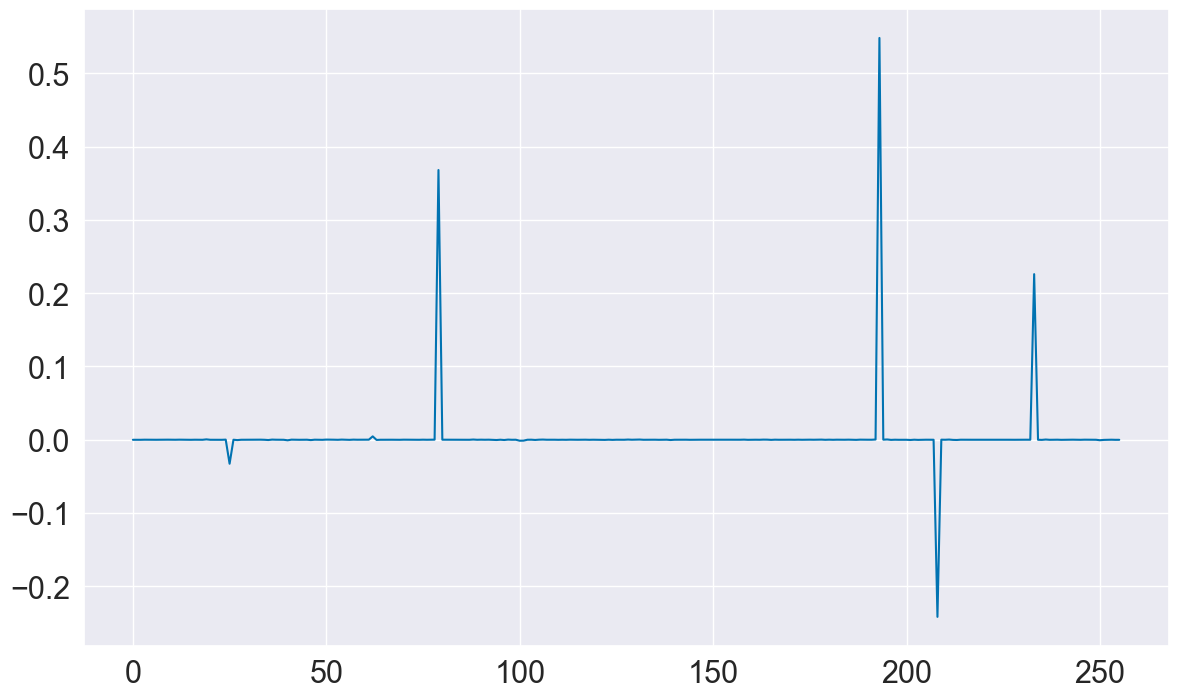

<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

In [34]:
plt.plot(x_opt[0])
plt.savefig('Figures/ex3_05.png', format="png", dpi=800, bbox_inches="tight")
plt.show()
plt.close

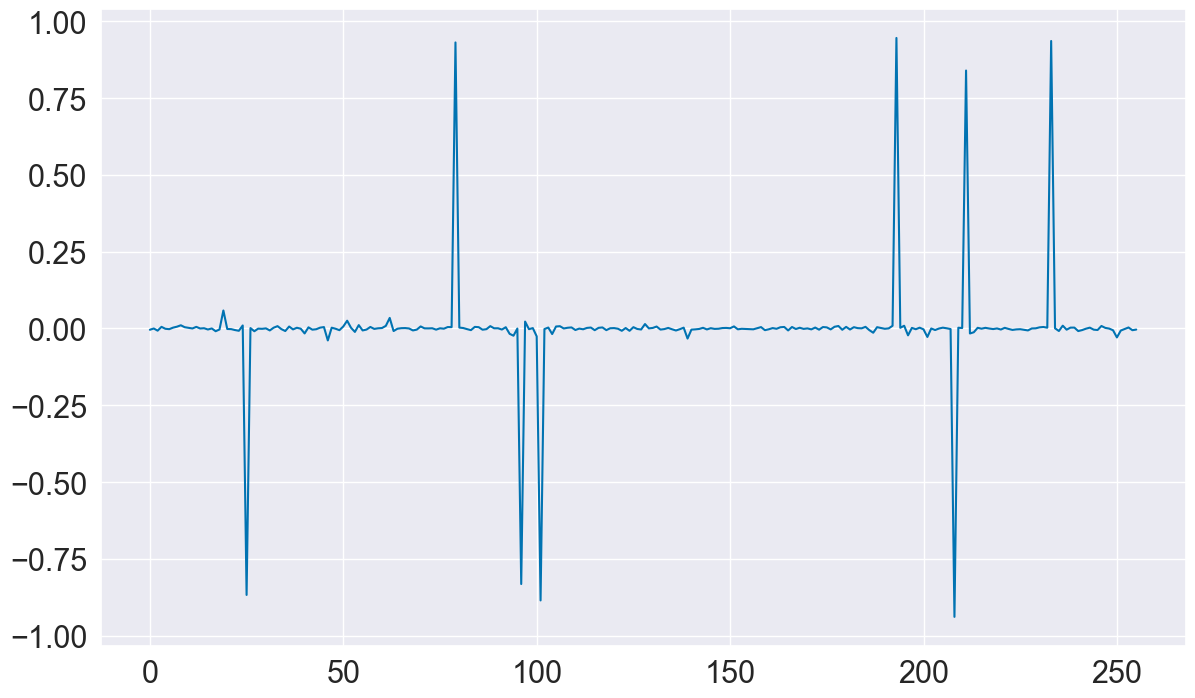

<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

In [35]:
plt.plot(x_opt[1])
plt.savefig('Figures/ex3_001.png', format="png", dpi=800, bbox_inches="tight")
plt.show()
plt.close

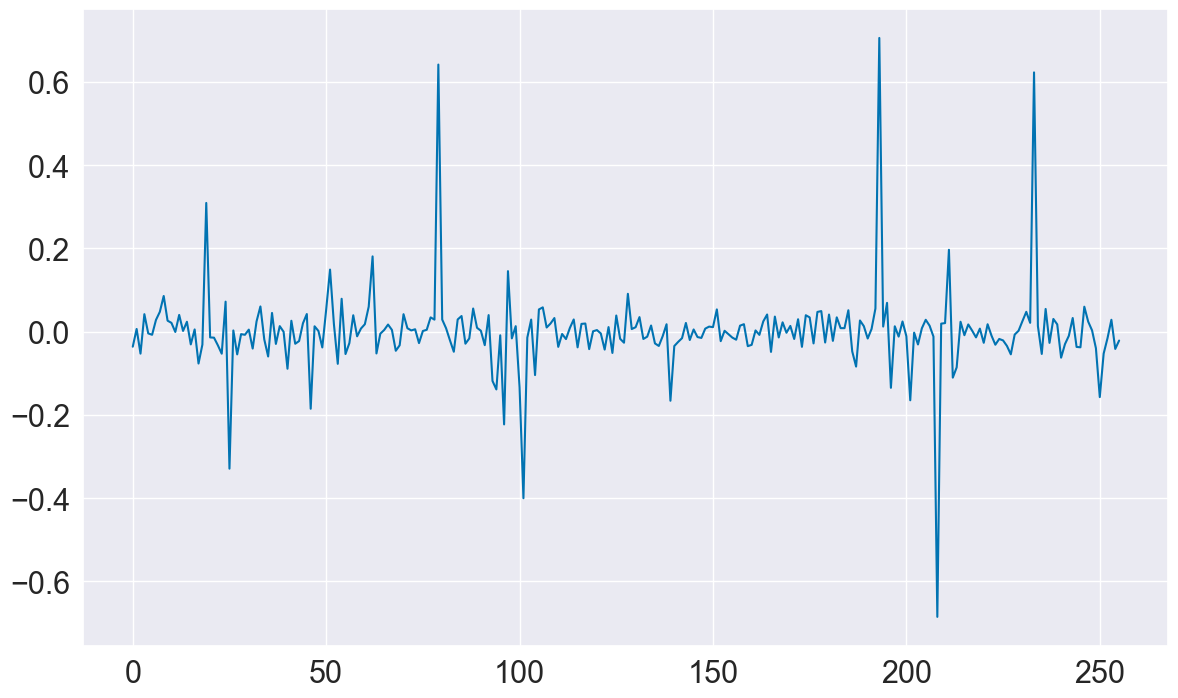

<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

In [36]:
plt.plot(x_opt[2])
plt.savefig('Figures/ex3_0001.png', format="png", dpi=800, bbox_inches="tight")
plt.show()
plt.close